In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def plotPoke(x):
    f, a = plt.subplots(2, 8, figsize=(8, 2))
    for i in range(8):
        a[0][i].imshow(x[i], cmap=plt.get_cmap('gray'))
        a[0,i].axis('off')
        a[1][i].imshow(x[i+8], cmap=plt.get_cmap('gray'))
        a[1,i].axis('off')
    f.show()
    plt.draw()

Input data shape: (792, 40, 40, 3)


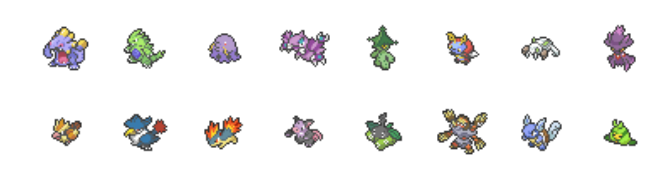

In [14]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 3), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./AE_RGB.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
print 'Input data shape: {}'.format(orig_img.shape)
plotPoke(orig_img)

In [4]:
# Parameters
learning_rate = 0.001
training_epochs = 1000
batch_size = 24
display_step = 100
examples_to_show = 8

# Network Parameters
n_input = [40, 40, 3] # Pokemon data input (img shape: 40*40*3)
n_channel1 = 16
n_channel2 = 32

# tf Graph input
X = tf.placeholder(tf.float32, [None]+n_input)

In [5]:
# Store layers weights & biases
weights = {
    # 5x5 conv, 3 inputs, 16 outputs
    'encoder_h1': tf.Variable(tf.truncated_normal([3, 3, 3, n_channel1], stddev=0.01)),
    # 5x5 conv, 16 inputs, 32 outputs
    'encoder_h2': tf.Variable(tf.truncated_normal([3, 3, n_channel1, n_channel2], stddev=0.01)),
    # 5x5 conv, 3 inputs, 16 outputs
    'decoder_h1': tf.Variable(tf.truncated_normal([3, 3, n_channel1, n_channel2], stddev=0.01)),
    # 5x5 conv, 16 inputs, 32 outputs
    'decoder_h2': tf.Variable(tf.truncated_normal([3, 3, 3, n_channel1], stddev=0.01))
}

biases = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_channel2], stddev=0.01)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'decoder_h2': tf.Variable(tf.truncated_normal([3], stddev=0.01))
}

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def deconv2d(x, W, b, out_shape, strides=1):
    x = tf.nn.conv2d_transpose(x, W, out_shape, strides=[1, strides, strides, 1], 
                               padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.sigmoid(x)
    
def maxPool(x, size=2, stride=2):
    _, argmax = tf.nn.max_pool_with_argmax(x, ksize=[1,size,size,1], strides=[1,stride,stride,1], padding = 'SAME')
    pool = tf.nn.max_pool(x, ksize = [1, size, size, 1], strides = [1, stride, stride, 1], padding = 'SAME')
    return pool, argmax

def unMaxPool(x, shape, size=2):
    inference = tf.image.resize_nearest_neighbor(x, size=tf.pack([shape[1]*size, shape[2]*size]))
    return inference
    
# Create model
def conv_net(x, weights, biases):
    # Convolution Layer and Max Pool Layer
    conv1 = conv2d(x, weights['encoder_h1'], biases['encoder_h1'])
    maxpool1, argmax1 = maxPool(conv1)
    # Convolution Layer and Max Pool Layer
    conv2 = conv2d(maxpool1, weights['encoder_h2'], biases['encoder_h2'])
    maxpool2, argmax2 = maxPool(conv2)

    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim1 = tf.pack([tf.shape(x)[0], 10, 10, n_channel1])
    deconv1 = deconv2d(maxpool2, weights['decoder_h1'], biases['decoder_h1'], out_dim1)
    unpool1 = unMaxPool(deconv1, out_dim1)
    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim2 = tf.pack([tf.shape(x)[0], 20, 20 ,3])
    deconv2 = deconv2d(unpool1, weights['decoder_h2'], biases['decoder_h2'], out_dim2)
    unpool2 = unMaxPool(deconv2, out_dim2)

    return unpool2

In [7]:
# Construct model
pred = conv_net(X, weights, biases)
y = X

# Define loss and optimizer
cost = tf.reduce_mean(tf.pow(pred - y, 2))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [8]:
# Initializing the variables
init = tf.global_variables_initializer()

# Create session and graph, initial variables
sess = tf.InteractiveSession()
sess.run(init)

In [ ]:
# Load previous trained model and rewrite to variables, if exists
# Before run this cell, you have to run the cell above first, to define variables and init it.

weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)

weightSaver.restore(sess, "./saved_model/Conv_AE_weights.ckpt")
biaseSaver.restore(sess, "./saved_model/Conv_AE_biases.ckpt")

print "Model restored."

In [11]:
total_batch = int(orig_img.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size-1
    for i in range(total_batch):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = orig_img[index]
        start = end+1; end = start+batch_size-1
        # Run optimization op (backprop) and loss op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print 'Epoch: {0:05d}   loss: {1:f}'.format(epoch+1, c)

print("Optimization Finished!")

Epoch: 00001   loss: 0.015597
Epoch: 00100   loss: 0.015538
Epoch: 00200   loss: 0.015503
Epoch: 00300   loss: 0.015496
Epoch: 00400   loss: 0.015476
Epoch: 00500   loss: 0.015459
Epoch: 00600   loss: 0.015458
Epoch: 00700   loss: 0.015445
Epoch: 00800   loss: 0.015434
Epoch: 00900   loss: 0.015427
Epoch: 01000   loss: 0.015420
Optimization Finished!


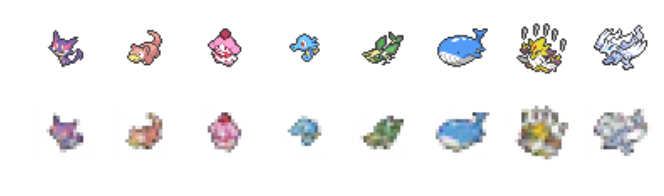

In [12]:
# Random select some pokemon to visualization
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
convAE = sess.run(
    pred, feed_dict={X: orig_img[index]})

# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[i]])
    a[0,i].axis('off')
    a[1][i].imshow(convAE[i])
    a[1,i].axis('off')
f.show()
plt.draw()

In [13]:
# Save trained Variables 
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)
save_path = weightSaver.save(sess, "./saved_model/Conv_AE_weights.ckpt")
save_path = biaseSaver.save(sess, "./saved_model/Conv_AE_biases.ckpt")